In [70]:
import pandas as pd
import numpy as np

*"El número básico de reproducción ($R_0$), pretende ser un indicador del contagio o transmisibilidad de agentes infecciosos y parasitarios. $R_0$ se encuentra a menudo en la bibliografía de epidemiología y salud pública y también se puede encontrar en la prensa popular. $R_0$ se ha descrito como una de las métricas fundamentales y más utilizadas para el estudio de la dinámica de las enfermedades infecciosas. Un $R_0$ para un evento de enfermedad infecciosa generalmente se informa como un valor numérico único o rango bajo-alto, y la interpretación generalmente se presenta como directa; se espera que continúe un brote si $R_0$ tiene un valor $>1$  y que termine si $R_0$ es  $<1$ . El tamaño potencial de un brote o epidemia a menudo se basa en la magnitud del valor $R_0$ para ese evento, y $R_0$ puede usarse para estimar la proporción de la población que debe vacunarse para eliminar una infección de esa población"* Tomado de: Delamater PL, Street EJ, Leslie TF, Yang Y, Jacobsen KH. Complexity of the Basic Reproduction Number ($R_0$). Emerg Infect Dis. 2019;25(1):1-4. https://dx.doi.org/10.3201/eid2501.171901

In [34]:
with open('../src/data/COVID/minsalud_api') as url:
    url = url.read()
    data_coronavirus = pd.read_json(url)

In [47]:
data_coronavirus.loc[data_coronavirus.loc[:, 'fis'] == 'Asintomatico', 'fis'] = data_coronavirus.loc[data_coronavirus.loc[:, 'fis'] == 'Asintomatico', 'fecha_de_notificaci_n']

In [49]:
for campo in ['fecha_de_notificaci_n', 'fis', 'fecha_diagnostico', 'fecha_recuperado', 'fecha_reporte_web', 'fecha_de_muerte']:
    data_coronavirus.loc[:, campo] = pd.to_datetime(data_coronavirus.loc[:, campo], errors = 'coerce')

In [53]:
data_coronavirus.sort_values('fis').reset_index(drop = True, inplace = True)

In [64]:
new_name = ['Bogota', 'Valle del Cauca', 'Antioquia', 'Bolivar', 'Huila', 'Meta', 'Risaralda', 'Norte de Santander', 'Caldas', 'Cundinamarca', 'Atlantico', 'Santander', 'Quindio', 'Tolima', 'Cauca', 'Magdalena', 'Cesar', 'San Andres y Providencia', 'Casanare', 'Nariño', 'Atlantico', 'Boyaca', 'Cordoba', 'Bolivar', 'Sucre', 'Magdalena', 'La Guajira', 'Valle del Cauca', 'Choco', 'Amazonas', 'Caqueta', 'Putumayo', 'Arauca', 'Vaupes', 'Guainia', 'Vichada', 'Guaviare']
old_name = ['Bogotá D.C.', 'Valle del Cauca', 'Antioquia', 'Cartagena D.T. y C.', 'Huila', 'Meta', 'Risaralda', 'Norte de Santander', 'Caldas', 'Cundinamarca', 'Barranquilla D.E.', 'Santander', 'Quindío', 'Tolima', 'Cauca', 'Santa Marta D.T. y C.', 'Cesar', 'Archipiélago de San Andrés Providencia y Santa Catalina', 'Casanare', 'Nariño', 'Atlántico', 'Boyacá', 'Córdoba', 'Bolívar', 'Sucre', 'Magdalena', 'La Guajira', 'Buenaventura D.E.', 'Chocó', 'Amazonas', 'Caquetá', 'Putumayo', 'Arauca', 'Vaupés', 'Guainía', 'Vichada', 'Guaviare']

In [65]:
data_coronavirus.departamento = data_coronavirus.departamento.replace(dict(zip(old_name, new_name)))

In [67]:
for campo in ['id_de_caso', 'c_digo_divipola', 'ciudad_de_ubicaci_n', 'departamento', 'atenci_n', 'edad', 'sexo', 'tipo', 'estado', 'pa_s_de_procedencia', 'tipo_recuperaci_n', 'codigo_departamento', 'codigo_pais']:
    try:data_coronavirus.loc[:, campo] = pd.to_numeric(data_coronavirus.loc[:, campo])
    except:data_coronavirus.loc[:, campo] = data_coronavirus.loc[:, campo].astype(str)

In [72]:
data_meteo = pd.DataFrame(columns = data_coronavirus.departamento.unique())

In [133]:
for departamento in data_coronavirus.departamento.unique()[:3]:
    data_coronavirus[data_coronavirus.departamento == departamento]

In [135]:
data_departamento = data_coronavirus[(data_coronavirus.departamento == departamento)&(data_coronavirus['tipo'] != 'Importado')].sort_values('fis')

infected = data_departamento.groupby('fis').count().id_de_caso
infected.name = 'infected'
deaths = data_departamento.groupby('fecha_de_muerte').count().id_de_caso
deaths.name = 'deaths'
recovered = data_departamento.groupby('fecha_recuperado').count().id_de_caso
recovered.name = 'recovered'

In [137]:
departamento

'Antioquia'

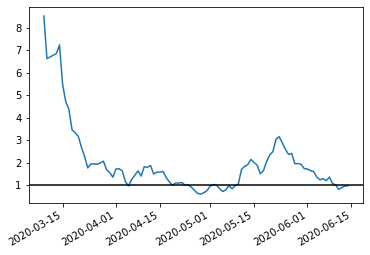

In [142]:
def rt(infected, recovered, deaths, transmission_period_days = 14, mean_window = 1):
    
    cases = pd.concat([infected, recovered, deaths], axis = 1)
    cases = cases.reindex(pd.date_range(cases.index.min(), )).fillna(0).cumsum()
    I = cases.infected - cases.recovered - cases.deaths
    return ((I.apply(lambda x: np.log(x)).diff()) * transmission_period_days + 1).rolling(mean_window).mean()

ax = rt(infected, recovered, deaths, mean_window=3).plot()
ax.axhline(1, color = 'k')

Metodología de Cálculo de  Rt  instantaneo
Suponga que  $D(t),R(t),F(t)∈Z+$  es el reporte diario de infectados, recuperados y fallecidos. Ahora tomando el valor acumulado del número de casos hasta el día  t  es:  $I(t)=∑^t_{k=0} D(k)−∑^t_{k=0} R(k)−∑^t_{k=0}F(k)$

El valor de  Rt  instantaneo se obtiene como la estimación de la razón de cambio del logaritmo natural de  I(t)  multiplicada por la duración estimada del periodo de transmisión de la infección (Covid19 8 días)  γ=8 

$$Rt=[logI(t)−logI(t−1)]γ+1 $$

El cálculo del  Rt  suavizado es una media móvil calculada sobre 3 puntos:  $\bar{R}_t=\frac{R_t+R_{t−1}+R_{t−2}}{3}$

In [ ]:
        df = select_department_tipo.groupby(by='fis').count()
        df_array = df.to_numpy()
        NI_infected_cases = df_array[:,0]
        Total_NI_infected_cases = np.cumsum(NI_infected_cases,0)
        time_vector = pd.to_datetime(df.index)
        #time_vector = datetime(df.index.to_numpy()).fromisoformat()
        tv = (time_vector-time_vector[0])
        cumulcases = Total_NI_infected_cases-Total_NI_infected_cases[0]+1

        Rtraw = 14.0*np.diff(np.log(cumulcases))+1
        Rfilt = sgnl.filtfilt([0.3333, 0.3333, 0.3333],[1.0],Rtraw)


        rt.loc[time_vector.date[1:], Departamento] = Rtraw
        rt_s.loc[time_vector.date[1:], Departamento] = Rfilt

In [ ]:
for Departamento in data.departamento.unique():
    try:
        now = datetime.datetime.now()

        if Departamento == 'Colombia':
          print('En Colombia hay: ')
          select_department = data
          select_department_tipo_Imp = data.loc[(data['tipo']=='Importado')]
          select_department_tipo = data.loc[(data['tipo']!='Importado')]
          select_department_fallec = data.loc[(data['atenci_n'] =='Fallecido')]
          select_department_recup = data.loc[(data['atenci_n'] =='Recuperado')]
          select_department_hospit = data.loc[(data['atenci_n'] =='Hospital')]
          select_department_UCI = data.loc[(data['atenci_n'] =='Hospital UCI')]
          select_department_En_Casa = data.loc[(data['atenci_n'] =='Casa')]
        else:
          select_department = data.loc[data['departamento'] == Departamento]
          select_department_tipo_Imp = data.loc[(data['departamento'] == Departamento) & (data['tipo']=='Importado')]
          select_department_tipo = data.loc[(data['departamento'] == Departamento) & (data['tipo']!='Importado')]
          select_department_fallec = data.loc[(data['departamento'] == Departamento) & (data['atenci_n'] =='Fallecido')]
          select_department_recup = data.loc[(data['departamento'] == Departamento) & (data['atenci_n'] =='Recuperado')]
          select_department_hospit = data.loc[(data['departamento'] == Departamento) & (data['atenci_n'] =='Hospital')]
          select_department_UCI = data.loc[(data['departamento'] == Departamento) & (data['atenci_n'] =='Hospital UCI')]
          select_department_En_Casa = data.loc[(data['departamento'] == Departamento) & (data['atenci_n'] =='Casa')]
          print('En departamento de ' + Departamento + ' hay: ')

        dates_diaf = data.loc[(data['fis'] =='Asintomático')].to_numpy()
        if dates_diaf.size>0 :
          data.loc[(data['fis'] =='Asintomático'),['fis']] = dates_diaf[:,1]
          data.fis = pd.to_datetime(data.fis)

        df = select_department_tipo.groupby(by='fis').count()
        df_array = df.to_numpy()
        NI_infected_cases = df_array[:,0]
        Total_NI_infected_cases = np.cumsum(NI_infected_cases,0)
        time_vector = pd.to_datetime(df.index)
        #time_vector = datetime(df.index.to_numpy()).fromisoformat()
        tv = (time_vector-time_vector[0])
        cumulcases = Total_NI_infected_cases-Total_NI_infected_cases[0]+1

        Rtraw = 14.0*np.diff(np.log(cumulcases))+1
        Rfilt = sgnl.filtfilt([0.3333, 0.3333, 0.3333],[1.0],Rtraw)


        rt.loc[time_vector.date[1:], Departamento] = Rtraw
        rt_s.loc[time_vector.date[1:], Departamento] = Rfilt

    except:pass